## Baseline Face Emotion Classifier

### Preprocessing

In [1]:
!pip install torch torchvision numpy matplotlib seaborn scikit-learn facenet-pytorch

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# ref: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
# don't run, just upload the zip
import kagglehub

path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
print("Path to dataset files:", path)

100%|██████████| 37.7M/37.7M [00:01<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2


In [3]:
# if running a different time, get raf_db.zip from Downloads/ and upload it to colab
import os
import zipfile

zipfile_path = 'raf_db.zip'
zip_extract_path = 'raf_db'

with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(zip_extract_path)

Emotion labels reference:
1. Surprise
2. Fear
3. Disgust
4. Happiness
5. Sadness
6. Anger
7. Neutral

In [4]:
# load labels from train/test
import pandas as pd

train_labels = pd.read_csv(f"{zip_extract_path}/raf_db/train_labels.csv")
test_labels = pd.read_csv(f"{zip_extract_path}/raf_db/test_labels.csv")

print("train dataset labels: ", train_labels.head())
print("test dataset labels: ", test_labels.head())

train dataset labels:                       image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
test dataset labels:                     image  label
0  test_0001_aligned.jpg      5
1  test_0002_aligned.jpg      1
2  test_0003_aligned.jpg      4
3  test_0004_aligned.jpg      1
4  test_0005_aligned.jpg      5


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)), # for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
from torch.utils.data import Dataset
from PIL import Image

class RAFDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # need to take into account the file structure: e.g. DATASET/train/1/train_0001_aligned.jpg
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # file walkthrough
        for label in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path): # should be subdirectory
                for img_name in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(int(label) - 1) # convert to zero indexing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_dir = "raf_db/raf_db/DATASET/train"
test_dir = "raf_db/raf_db/DATASET/test"

train_dataset = RAFDBDataset(root_dir=train_dir, transform=transform)
test_dataset = RAFDBDataset(root_dir=test_dir, transform=transform)

print(f"train data size: {len(train_dataset)}, test data size: {len(test_dataset)}")

# test
print("example path:", train_dataset.image_paths[0])
print("example label:", train_dataset.labels[0])

train data size: 12271, test data size: 3068
example path: raf_db/raf_db/DATASET/train/1/train_03441_aligned.jpg
example label: 0


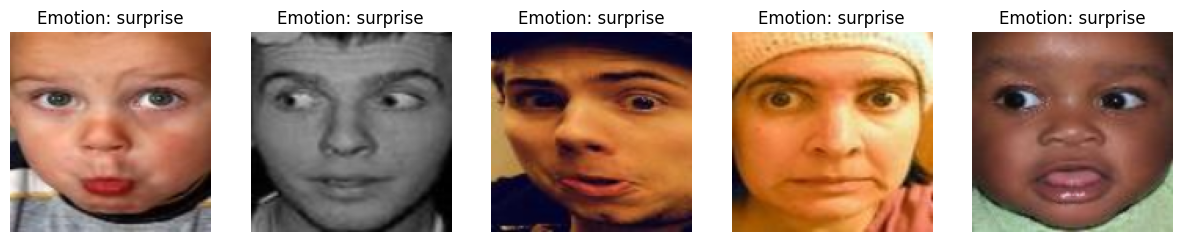

In [8]:
emotion_labels = ["surprise", "fear", "disgust", "happiness", "sadness", "anger", "neutral"]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5 # undo the transform

    axes[i].imshow(img)
    axes[i].set_title(f"Emotion: {emotion_labels[label]}")
    axes[i].axis("off")

plt.show()

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"training batches: {len(train_loader)}")
print(f"test batches: {len(test_loader)}")

training batches: 384
test batches: 96


### Train ResNet model from scratch

In [10]:
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

# full ResNet architecture
class ResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # blocks for ResNet
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
model = ResNet(num_classes=num_classes).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [11]:
import torch.optim as optim

# use standard cross entropy loss and adam optimizer with lr=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import time
import numpy as np
from tqdm import tqdm

# train from scratch!
num_epochs = 15
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as t:
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)

            # do forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for metrics tracking
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            t.set_postfix(loss=running_loss / (total / 32), acc=correct / total)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Time: {end_time - start_time:.2f}s")

print("training done!")


Epoch [1/15]: 100%|██████████| 384/384 [00:29<00:00, 12.80batch/s, acc=0.596, loss=1.11]


Epoch [1/15] - Loss: 1.1113, Accuracy: 0.5956, Time: 30.00s


Epoch [2/15]: 100%|██████████| 384/384 [00:27<00:00, 13.88batch/s, acc=0.738, loss=0.729]


Epoch [2/15] - Loss: 0.7282, Accuracy: 0.7383, Time: 27.68s


Epoch [3/15]: 100%|██████████| 384/384 [00:27<00:00, 13.93batch/s, acc=0.817, loss=0.521]


Epoch [3/15] - Loss: 0.5205, Accuracy: 0.8167, Time: 27.57s


Epoch [4/15]: 100%|██████████| 384/384 [00:27<00:00, 13.92batch/s, acc=0.878, loss=0.348]


Epoch [4/15] - Loss: 0.3475, Accuracy: 0.8778, Time: 27.60s


Epoch [5/15]: 100%|██████████| 384/384 [00:28<00:00, 13.57batch/s, acc=0.928, loss=0.213]


Epoch [5/15] - Loss: 0.2125, Accuracy: 0.9279, Time: 28.31s


Epoch [6/15]: 100%|██████████| 384/384 [00:30<00:00, 12.79batch/s, acc=0.952, loss=0.141]


Epoch [6/15] - Loss: 0.1411, Accuracy: 0.9521, Time: 30.04s


Epoch [7/15]: 100%|██████████| 384/384 [00:29<00:00, 12.98batch/s, acc=0.958, loss=0.122]


Epoch [7/15] - Loss: 0.1223, Accuracy: 0.9582, Time: 29.60s


Epoch [8/15]: 100%|██████████| 384/384 [00:28<00:00, 13.59batch/s, acc=0.964, loss=0.1]


Epoch [8/15] - Loss: 0.0999, Accuracy: 0.9643, Time: 28.26s


Epoch [9/15]: 100%|██████████| 384/384 [00:27<00:00, 13.87batch/s, acc=0.972, loss=0.0817]


Epoch [9/15] - Loss: 0.0816, Accuracy: 0.9725, Time: 27.69s


Epoch [10/15]: 100%|██████████| 384/384 [00:27<00:00, 13.78batch/s, acc=0.974, loss=0.0776]


Epoch [10/15] - Loss: 0.0775, Accuracy: 0.9740, Time: 27.86s


Epoch [11/15]: 100%|██████████| 384/384 [00:27<00:00, 13.87batch/s, acc=0.975, loss=0.0718]


Epoch [11/15] - Loss: 0.0717, Accuracy: 0.9748, Time: 27.70s


Epoch [12/15]: 100%|██████████| 384/384 [00:28<00:00, 13.51batch/s, acc=0.972, loss=0.0792]


Epoch [12/15] - Loss: 0.0791, Accuracy: 0.9725, Time: 28.43s


Epoch [13/15]: 100%|██████████| 384/384 [00:27<00:00, 13.86batch/s, acc=0.979, loss=0.0624]


Epoch [13/15] - Loss: 0.0623, Accuracy: 0.9791, Time: 27.70s


Epoch [14/15]: 100%|██████████| 384/384 [00:27<00:00, 13.83batch/s, acc=0.986, loss=0.0416]


Epoch [14/15] - Loss: 0.0415, Accuracy: 0.9861, Time: 27.77s


Epoch [15/15]: 100%|██████████| 384/384 [00:27<00:00, 13.85batch/s, acc=0.984, loss=0.052]

Epoch [15/15] - Loss: 0.0519, Accuracy: 0.9839, Time: 27.73s
training done!


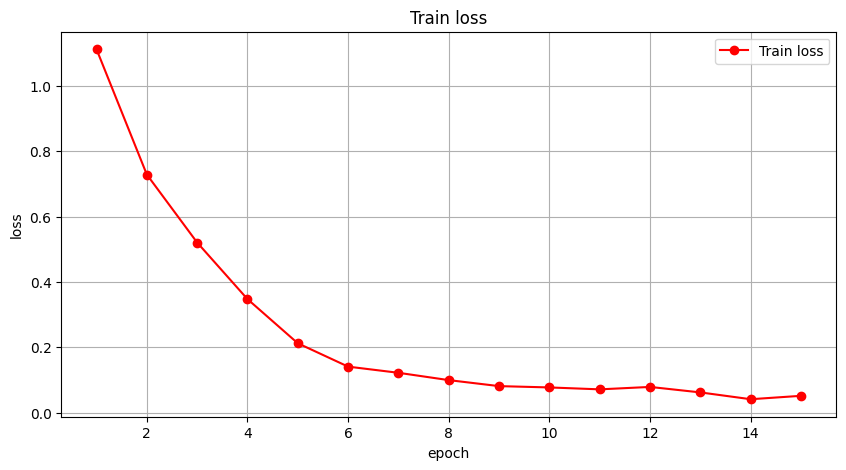

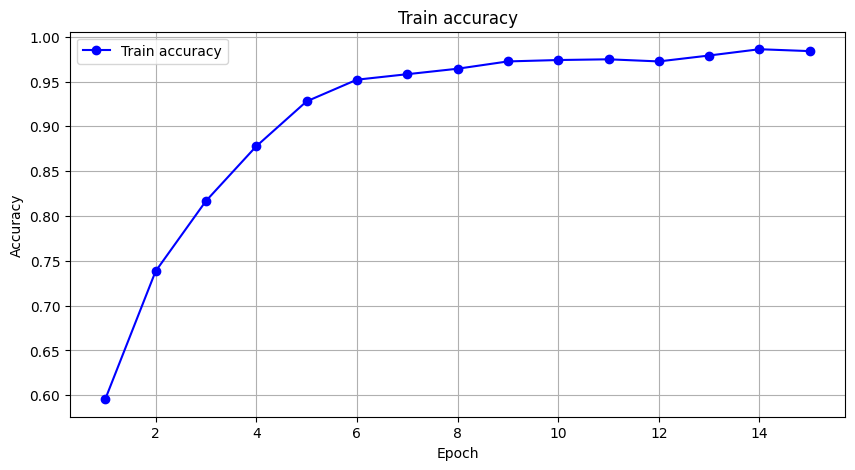

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='r', label="Train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, marker='o', linestyle='-', color='b', label="Train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train accuracy")
plt.legend()
plt.grid()
plt.show()

### Hyperparameter optimization for testing

In [12]:
import itertools

learning_rates = [1e-3, 1e-4, 1e-5]
optimizers = ["adam", "sgd"]

all_train_losses = {}
all_train_accs = {}

In [14]:
import itertools
from tqdm import tqdm

learning_rates = [1e-3, 1e-4, 1e-5]
optimizers = ["adam", "sgd"]

all_train_losses = {}
all_train_accs = {}

# so we can save the model and invoke it later
best_model_state = None
best_acc = 0.0
best_hyperparams = ""
best_model_filename = ""

# grid search / random search
for lr, opt_name in itertools.product(learning_rates, optimizers):
    print(f"\nLR={lr}, optimizer={opt_name}\n")
    model = ResNet(num_classes=7).to(device) # reset

    if opt_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif opt_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses, train_accs = [], []
    for epoch in range(15):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        with tqdm(train_loader, desc=f"LR={lr}, optimizer={opt_name} epoch [{epoch+1}/15]", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                t.set_postfix(loss=running_loss / (total / 32), acc=correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print(f"epoch [{epoch+1}/15] - loss: {train_loss:.4f}, train acc: {train_acc:.4f}")

    key = f"LR={lr}, optimizer={opt_name}"
    all_train_losses[key] = train_losses
    all_train_accs[key] = train_accs

    # save best model
    if train_acc > best_acc:
        best_acc = train_acc
        best_model_state = model.state_dict() # weights only, not the whole model
        best_hyperparams = key
        best_model_filename = f"best_resnet_{key.replace(', ', '_').replace('=', '').replace('.', '')}.pth"
        torch.save(best_model_state, best_model_filename)
        print(f"saved best model with train acc = {best_acc:.4f} at {best_model_filename}")



LR=0.001, optimizer=adam



LR=0.001, optimizer=adam epoch [1/15]: 100%|██████████| 384/384 [00:28<00:00, 13.59batch/s, acc=0.492, loss=1.39]


epoch [1/15] - loss: 1.3895, train acc: 0.4919


LR=0.001, optimizer=adam epoch [2/15]: 100%|██████████| 384/384 [00:26<00:00, 14.58batch/s, acc=0.642, loss=0.991]


epoch [2/15] - loss: 0.9900, train acc: 0.6421


LR=0.001, optimizer=adam epoch [3/15]: 100%|██████████| 384/384 [00:25<00:00, 14.82batch/s, acc=0.703, loss=0.834]


epoch [3/15] - loss: 0.8331, train acc: 0.7029


LR=0.001, optimizer=adam epoch [4/15]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.741, loss=0.729]


epoch [4/15] - loss: 0.7276, train acc: 0.7412


LR=0.001, optimizer=adam epoch [5/15]: 100%|██████████| 384/384 [00:26<00:00, 14.75batch/s, acc=0.782, loss=0.618]


epoch [5/15] - loss: 0.6174, train acc: 0.7816


LR=0.001, optimizer=adam epoch [6/15]: 100%|██████████| 384/384 [00:25<00:00, 14.80batch/s, acc=0.807, loss=0.542]


epoch [6/15] - loss: 0.5412, train acc: 0.8069


LR=0.001, optimizer=adam epoch [7/15]: 100%|██████████| 384/384 [00:26<00:00, 14.75batch/s, acc=0.841, loss=0.443]


epoch [7/15] - loss: 0.4423, train acc: 0.8413


LR=0.001, optimizer=adam epoch [8/15]: 100%|██████████| 384/384 [00:26<00:00, 14.76batch/s, acc=0.88, loss=0.337]


epoch [8/15] - loss: 0.3366, train acc: 0.8801


LR=0.001, optimizer=adam epoch [9/15]: 100%|██████████| 384/384 [00:25<00:00, 14.78batch/s, acc=0.909, loss=0.256]


epoch [9/15] - loss: 0.2553, train acc: 0.9090


LR=0.001, optimizer=adam epoch [10/15]: 100%|██████████| 384/384 [00:26<00:00, 14.66batch/s, acc=0.933, loss=0.187]


epoch [10/15] - loss: 0.1870, train acc: 0.9326


LR=0.001, optimizer=adam epoch [11/15]: 100%|██████████| 384/384 [00:26<00:00, 14.64batch/s, acc=0.948, loss=0.148]


epoch [11/15] - loss: 0.1476, train acc: 0.9476


LR=0.001, optimizer=adam epoch [12/15]: 100%|██████████| 384/384 [00:26<00:00, 14.72batch/s, acc=0.963, loss=0.105]


epoch [12/15] - loss: 0.1052, train acc: 0.9635


LR=0.001, optimizer=adam epoch [13/15]: 100%|██████████| 384/384 [00:26<00:00, 14.68batch/s, acc=0.967, loss=0.0934]


epoch [13/15] - loss: 0.0933, train acc: 0.9673


LR=0.001, optimizer=adam epoch [14/15]: 100%|██████████| 384/384 [00:26<00:00, 14.74batch/s, acc=0.971, loss=0.0876]


epoch [14/15] - loss: 0.0874, train acc: 0.9707


LR=0.001, optimizer=adam epoch [15/15]: 100%|██████████| 384/384 [00:26<00:00, 14.77batch/s, acc=0.976, loss=0.0666]


epoch [15/15] - loss: 0.0665, train acc: 0.9759
saved best model with train acc = 0.9759 at best_resnet_LR0001_optimizeradam.pth

LR=0.001, optimizer=sgd



LR=0.001, optimizer=sgd epoch [1/15]: 100%|██████████| 384/384 [00:25<00:00, 15.20batch/s, acc=0.537, loss=1.26]


epoch [1/15] - loss: 1.2620, train acc: 0.5371


LR=0.001, optimizer=sgd epoch [2/15]: 100%|██████████| 384/384 [00:25<00:00, 15.04batch/s, acc=0.699, loss=0.855]


epoch [2/15] - loss: 0.8534, train acc: 0.6986


LR=0.001, optimizer=sgd epoch [3/15]: 100%|██████████| 384/384 [00:25<00:00, 15.05batch/s, acc=0.767, loss=0.653]


epoch [3/15] - loss: 0.6521, train acc: 0.7668


LR=0.001, optimizer=sgd epoch [4/15]: 100%|██████████| 384/384 [00:25<00:00, 15.14batch/s, acc=0.846, loss=0.453]


epoch [4/15] - loss: 0.4528, train acc: 0.8458


LR=0.001, optimizer=sgd epoch [5/15]: 100%|██████████| 384/384 [00:25<00:00, 15.13batch/s, acc=0.892, loss=0.31]


epoch [5/15] - loss: 0.3092, train acc: 0.8923


LR=0.001, optimizer=sgd epoch [6/15]: 100%|██████████| 384/384 [00:26<00:00, 14.51batch/s, acc=0.931, loss=0.202]


epoch [6/15] - loss: 0.2018, train acc: 0.9313


LR=0.001, optimizer=sgd epoch [7/15]: 100%|██████████| 384/384 [00:25<00:00, 15.11batch/s, acc=0.962, loss=0.118]


epoch [7/15] - loss: 0.1177, train acc: 0.9624


LR=0.001, optimizer=sgd epoch [8/15]: 100%|██████████| 384/384 [00:25<00:00, 15.03batch/s, acc=0.972, loss=0.0822]


epoch [8/15] - loss: 0.0821, train acc: 0.9720


LR=0.001, optimizer=sgd epoch [9/15]: 100%|██████████| 384/384 [00:25<00:00, 15.09batch/s, acc=0.982, loss=0.0585]


epoch [9/15] - loss: 0.0584, train acc: 0.9824


LR=0.001, optimizer=sgd epoch [10/15]: 100%|██████████| 384/384 [00:25<00:00, 15.12batch/s, acc=0.989, loss=0.0381]


epoch [10/15] - loss: 0.0380, train acc: 0.9886


LR=0.001, optimizer=sgd epoch [11/15]: 100%|██████████| 384/384 [00:25<00:00, 15.05batch/s, acc=0.992, loss=0.026]


epoch [11/15] - loss: 0.0260, train acc: 0.9918


LR=0.001, optimizer=sgd epoch [12/15]: 100%|██████████| 384/384 [00:25<00:00, 14.99batch/s, acc=0.994, loss=0.0209]


epoch [12/15] - loss: 0.0209, train acc: 0.9938


LR=0.001, optimizer=sgd epoch [13/15]: 100%|██████████| 384/384 [00:25<00:00, 15.14batch/s, acc=0.997, loss=0.0124]


epoch [13/15] - loss: 0.0124, train acc: 0.9972


LR=0.001, optimizer=sgd epoch [14/15]: 100%|██████████| 384/384 [00:25<00:00, 15.09batch/s, acc=0.998, loss=0.00651]


epoch [14/15] - loss: 0.0065, train acc: 0.9985


LR=0.001, optimizer=sgd epoch [15/15]: 100%|██████████| 384/384 [00:25<00:00, 15.16batch/s, acc=0.999, loss=0.00485]


epoch [15/15] - loss: 0.0048, train acc: 0.9992
saved best model with train acc = 0.9992 at best_resnet_LR0001_optimizersgd.pth

LR=0.0001, optimizer=adam



LR=0.0001, optimizer=adam epoch [1/15]: 100%|██████████| 384/384 [00:26<00:00, 14.70batch/s, acc=0.594, loss=1.12]


epoch [1/15] - loss: 1.1161, train acc: 0.5942


LR=0.0001, optimizer=adam epoch [2/15]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.735, loss=0.75]


epoch [2/15] - loss: 0.7485, train acc: 0.7347


LR=0.0001, optimizer=adam epoch [3/15]: 100%|██████████| 384/384 [00:26<00:00, 14.71batch/s, acc=0.816, loss=0.533]


epoch [3/15] - loss: 0.5323, train acc: 0.8163


LR=0.0001, optimizer=adam epoch [4/15]: 100%|██████████| 384/384 [00:26<00:00, 14.56batch/s, acc=0.88, loss=0.342]


epoch [4/15] - loss: 0.3410, train acc: 0.8796


LR=0.0001, optimizer=adam epoch [5/15]: 100%|██████████| 384/384 [00:26<00:00, 14.60batch/s, acc=0.927, loss=0.22]


epoch [5/15] - loss: 0.2199, train acc: 0.9270


LR=0.0001, optimizer=adam epoch [6/15]: 100%|██████████| 384/384 [00:26<00:00, 14.58batch/s, acc=0.952, loss=0.145]


epoch [6/15] - loss: 0.1448, train acc: 0.9517


LR=0.0001, optimizer=adam epoch [7/15]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.967, loss=0.099]


epoch [7/15] - loss: 0.0988, train acc: 0.9668


LR=0.0001, optimizer=adam epoch [8/15]: 100%|██████████| 384/384 [00:26<00:00, 14.75batch/s, acc=0.968, loss=0.094]


epoch [8/15] - loss: 0.0938, train acc: 0.9681


LR=0.0001, optimizer=adam epoch [9/15]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.971, loss=0.0825]


epoch [9/15] - loss: 0.0824, train acc: 0.9714


LR=0.0001, optimizer=adam epoch [10/15]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.973, loss=0.0813]


epoch [10/15] - loss: 0.0812, train acc: 0.9729


LR=0.0001, optimizer=adam epoch [11/15]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.979, loss=0.0667]


epoch [11/15] - loss: 0.0667, train acc: 0.9788


LR=0.0001, optimizer=adam epoch [12/15]: 100%|██████████| 384/384 [00:26<00:00, 14.74batch/s, acc=0.971, loss=0.0814]


epoch [12/15] - loss: 0.0813, train acc: 0.9709


LR=0.0001, optimizer=adam epoch [13/15]: 100%|██████████| 384/384 [00:26<00:00, 14.60batch/s, acc=0.981, loss=0.0562]


epoch [13/15] - loss: 0.0562, train acc: 0.9813


LR=0.0001, optimizer=adam epoch [14/15]: 100%|██████████| 384/384 [00:26<00:00, 14.76batch/s, acc=0.987, loss=0.0385]


epoch [14/15] - loss: 0.0384, train acc: 0.9871


LR=0.0001, optimizer=adam epoch [15/15]: 100%|██████████| 384/384 [00:26<00:00, 14.76batch/s, acc=0.977, loss=0.0677]


epoch [15/15] - loss: 0.0676, train acc: 0.9773

LR=0.0001, optimizer=sgd



LR=0.0001, optimizer=sgd epoch [1/15]: 100%|██████████| 384/384 [00:25<00:00, 15.26batch/s, acc=0.403, loss=1.58]


epoch [1/15] - loss: 1.5756, train acc: 0.4031


LR=0.0001, optimizer=sgd epoch [2/15]: 100%|██████████| 384/384 [00:25<00:00, 15.18batch/s, acc=0.487, loss=1.39]


epoch [2/15] - loss: 1.3900, train acc: 0.4870


LR=0.0001, optimizer=sgd epoch [3/15]: 100%|██████████| 384/384 [00:25<00:00, 15.06batch/s, acc=0.578, loss=1.18]


epoch [3/15] - loss: 1.1817, train acc: 0.5779


LR=0.0001, optimizer=sgd epoch [4/15]: 100%|██████████| 384/384 [00:25<00:00, 15.17batch/s, acc=0.639, loss=1.03]


epoch [4/15] - loss: 1.0256, train acc: 0.6391


LR=0.0001, optimizer=sgd epoch [5/15]: 100%|██████████| 384/384 [00:25<00:00, 14.99batch/s, acc=0.687, loss=0.897]


epoch [5/15] - loss: 0.8962, train acc: 0.6873


LR=0.0001, optimizer=sgd epoch [6/15]: 100%|██████████| 384/384 [00:25<00:00, 14.90batch/s, acc=0.734, loss=0.776]


epoch [6/15] - loss: 0.7752, train acc: 0.7343


LR=0.0001, optimizer=sgd epoch [7/15]: 100%|██████████| 384/384 [00:25<00:00, 14.89batch/s, acc=0.778, loss=0.655]


epoch [7/15] - loss: 0.6537, train acc: 0.7776


LR=0.0001, optimizer=sgd epoch [8/15]: 100%|██████████| 384/384 [00:25<00:00, 14.99batch/s, acc=0.825, loss=0.543]


epoch [8/15] - loss: 0.5418, train acc: 0.8248


LR=0.0001, optimizer=sgd epoch [9/15]: 100%|██████████| 384/384 [00:25<00:00, 14.89batch/s, acc=0.868, loss=0.432]


epoch [9/15] - loss: 0.4312, train acc: 0.8682


LR=0.0001, optimizer=sgd epoch [10/15]: 100%|██████████| 384/384 [00:25<00:00, 14.91batch/s, acc=0.905, loss=0.334]


epoch [10/15] - loss: 0.3336, train acc: 0.9050


LR=0.0001, optimizer=sgd epoch [11/15]: 100%|██████████| 384/384 [00:25<00:00, 14.94batch/s, acc=0.931, loss=0.258]


epoch [11/15] - loss: 0.2580, train acc: 0.9308


LR=0.0001, optimizer=sgd epoch [12/15]: 100%|██████████| 384/384 [00:25<00:00, 14.90batch/s, acc=0.956, loss=0.184]


epoch [12/15] - loss: 0.1836, train acc: 0.9561


LR=0.0001, optimizer=sgd epoch [13/15]: 100%|██████████| 384/384 [00:25<00:00, 15.04batch/s, acc=0.972, loss=0.139]


epoch [13/15] - loss: 0.1387, train acc: 0.9716


LR=0.0001, optimizer=sgd epoch [14/15]: 100%|██████████| 384/384 [00:25<00:00, 15.10batch/s, acc=0.979, loss=0.108]


epoch [14/15] - loss: 0.1079, train acc: 0.9795


LR=0.0001, optimizer=sgd epoch [15/15]: 100%|██████████| 384/384 [00:25<00:00, 15.01batch/s, acc=0.986, loss=0.0809]


epoch [15/15] - loss: 0.0808, train acc: 0.9863

LR=1e-05, optimizer=adam



LR=1e-05, optimizer=adam epoch [1/15]: 100%|██████████| 384/384 [00:26<00:00, 14.61batch/s, acc=0.461, loss=1.47]


epoch [1/15] - loss: 1.4708, train acc: 0.4613


LR=1e-05, optimizer=adam epoch [2/15]: 100%|██████████| 384/384 [00:26<00:00, 14.63batch/s, acc=0.643, loss=1.02]


epoch [2/15] - loss: 1.0178, train acc: 0.6432


LR=1e-05, optimizer=adam epoch [3/15]: 100%|██████████| 384/384 [00:26<00:00, 14.68batch/s, acc=0.761, loss=0.72]


epoch [3/15] - loss: 0.7185, train acc: 0.7615


LR=1e-05, optimizer=adam epoch [4/15]: 100%|██████████| 384/384 [00:26<00:00, 14.47batch/s, acc=0.863, loss=0.462]


epoch [4/15] - loss: 0.4609, train acc: 0.8629


LR=1e-05, optimizer=adam epoch [5/15]: 100%|██████████| 384/384 [00:26<00:00, 14.70batch/s, acc=0.928, loss=0.273]


epoch [5/15] - loss: 0.2730, train acc: 0.9280


LR=1e-05, optimizer=adam epoch [6/15]: 100%|██████████| 384/384 [00:26<00:00, 14.63batch/s, acc=0.967, loss=0.157]


epoch [6/15] - loss: 0.1571, train acc: 0.9671


LR=1e-05, optimizer=adam epoch [7/15]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.983, loss=0.0994]


epoch [7/15] - loss: 0.0993, train acc: 0.9835


LR=1e-05, optimizer=adam epoch [8/15]: 100%|██████████| 384/384 [00:26<00:00, 14.70batch/s, acc=0.993, loss=0.0629]


epoch [8/15] - loss: 0.0628, train acc: 0.9925


LR=1e-05, optimizer=adam epoch [9/15]: 100%|██████████| 384/384 [00:26<00:00, 14.72batch/s, acc=0.993, loss=0.0525]


epoch [9/15] - loss: 0.0524, train acc: 0.9926


LR=1e-05, optimizer=adam epoch [10/15]: 100%|██████████| 384/384 [00:26<00:00, 14.50batch/s, acc=0.996, loss=0.0382]


epoch [10/15] - loss: 0.0381, train acc: 0.9958


LR=1e-05, optimizer=adam epoch [11/15]: 100%|██████████| 384/384 [00:26<00:00, 14.65batch/s, acc=0.995, loss=0.0358]


epoch [11/15] - loss: 0.0358, train acc: 0.9949


LR=1e-05, optimizer=adam epoch [12/15]: 100%|██████████| 384/384 [00:26<00:00, 14.59batch/s, acc=0.994, loss=0.0328]


epoch [12/15] - loss: 0.0328, train acc: 0.9945


LR=1e-05, optimizer=adam epoch [13/15]: 100%|██████████| 384/384 [00:26<00:00, 14.61batch/s, acc=0.995, loss=0.0328]


epoch [13/15] - loss: 0.0328, train acc: 0.9951


LR=1e-05, optimizer=adam epoch [14/15]: 100%|██████████| 384/384 [00:27<00:00, 14.13batch/s, acc=0.994, loss=0.0316]


epoch [14/15] - loss: 0.0316, train acc: 0.9943


LR=1e-05, optimizer=adam epoch [15/15]: 100%|██████████| 384/384 [00:27<00:00, 14.05batch/s, acc=0.996, loss=0.0255]


epoch [15/15] - loss: 0.0255, train acc: 0.9963

LR=1e-05, optimizer=sgd



LR=1e-05, optimizer=sgd epoch [1/15]: 100%|██████████| 384/384 [00:26<00:00, 14.31batch/s, acc=0.323, loss=1.76]


epoch [1/15] - loss: 1.7573, train acc: 0.3231


LR=1e-05, optimizer=sgd epoch [2/15]: 100%|██████████| 384/384 [00:25<00:00, 14.81batch/s, acc=0.393, loss=1.61]


epoch [2/15] - loss: 1.6073, train acc: 0.3926


LR=1e-05, optimizer=sgd epoch [3/15]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.398, loss=1.58]


epoch [3/15] - loss: 1.5787, train acc: 0.3982


LR=1e-05, optimizer=sgd epoch [4/15]: 100%|██████████| 384/384 [00:26<00:00, 14.69batch/s, acc=0.405, loss=1.56]


epoch [4/15] - loss: 1.5591, train acc: 0.4052


LR=1e-05, optimizer=sgd epoch [5/15]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.413, loss=1.54]


epoch [5/15] - loss: 1.5405, train acc: 0.4133


LR=1e-05, optimizer=sgd epoch [6/15]: 100%|██████████| 384/384 [00:26<00:00, 14.71batch/s, acc=0.423, loss=1.53]


epoch [6/15] - loss: 1.5239, train acc: 0.4234


LR=1e-05, optimizer=sgd epoch [7/15]: 100%|██████████| 384/384 [00:26<00:00, 14.59batch/s, acc=0.426, loss=1.51]


epoch [7/15] - loss: 1.5089, train acc: 0.4260


LR=1e-05, optimizer=sgd epoch [8/15]: 100%|██████████| 384/384 [00:26<00:00, 14.64batch/s, acc=0.437, loss=1.49]


epoch [8/15] - loss: 1.4913, train acc: 0.4367


LR=1e-05, optimizer=sgd epoch [9/15]: 100%|██████████| 384/384 [00:25<00:00, 14.87batch/s, acc=0.449, loss=1.47]


epoch [9/15] - loss: 1.4728, train acc: 0.4485


LR=1e-05, optimizer=sgd epoch [10/15]: 100%|██████████| 384/384 [00:26<00:00, 14.72batch/s, acc=0.453, loss=1.46]


epoch [10/15] - loss: 1.4570, train acc: 0.4533


LR=1e-05, optimizer=sgd epoch [11/15]: 100%|██████████| 384/384 [00:25<00:00, 14.96batch/s, acc=0.461, loss=1.44]


epoch [11/15] - loss: 1.4358, train acc: 0.4613


LR=1e-05, optimizer=sgd epoch [12/15]: 100%|██████████| 384/384 [00:25<00:00, 14.97batch/s, acc=0.479, loss=1.41]


epoch [12/15] - loss: 1.4125, train acc: 0.4787


LR=1e-05, optimizer=sgd epoch [13/15]: 100%|██████████| 384/384 [00:25<00:00, 14.89batch/s, acc=0.491, loss=1.39]


epoch [13/15] - loss: 1.3885, train acc: 0.4912


LR=1e-05, optimizer=sgd epoch [14/15]: 100%|██████████| 384/384 [00:25<00:00, 14.99batch/s, acc=0.51, loss=1.37]


epoch [14/15] - loss: 1.3635, train acc: 0.5102


LR=1e-05, optimizer=sgd epoch [15/15]: 100%|██████████| 384/384 [00:25<00:00, 14.95batch/s, acc=0.527, loss=1.34]

epoch [15/15] - loss: 1.3342, train acc: 0.5270


In [15]:
print(best_model_filename)

best_resnet_LR0001_optimizersgd.pth


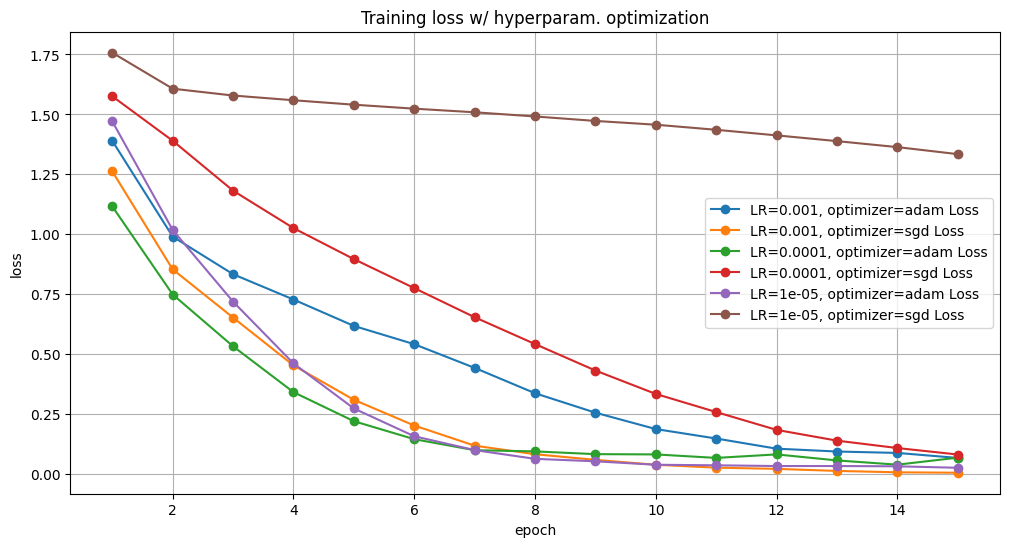

In [16]:
plt.figure(figsize=(12, 6))
for key, losses in all_train_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f"{key} Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training loss w/ hyperparam. optimization")
plt.legend()
plt.grid(True)
plt.show()

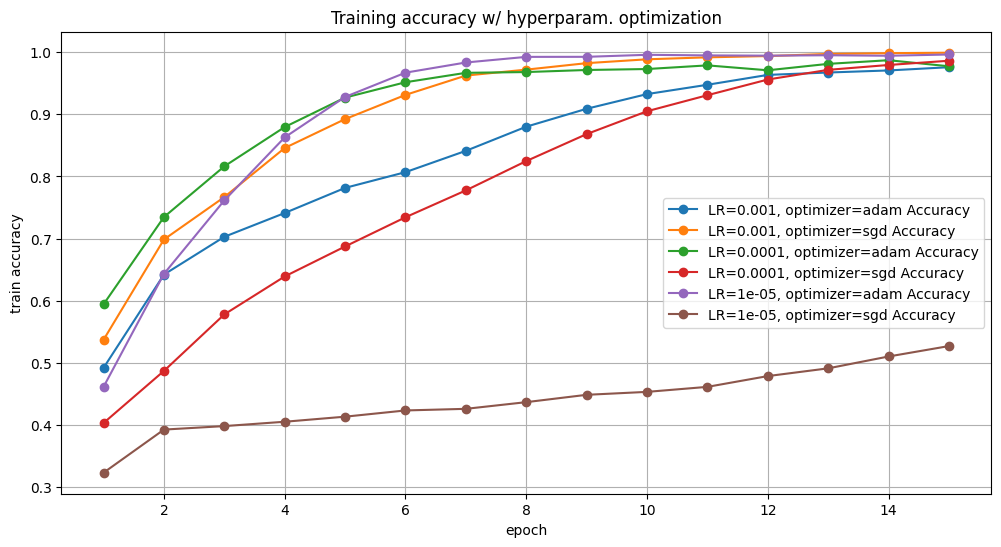

In [17]:
plt.figure(figsize=(12, 6))
for key, accs in all_train_accs.items():
    plt.plot(range(1, len(accs) + 1), accs, marker='o', label=f"{key} Accuracy")
plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.title("Training accuracy w/ hyperparam. optimization")
plt.legend()
plt.grid(True)
plt.show()

From here, we can conclude that LR = 0.001 with SGD optimizer had the best training results.

In [18]:
# evaluate / test
best_model = ResNet(num_classes=7).to(device)
best_model.load_state_dict(torch.load(best_model_filename))
best_model.eval()

<ipython-input-18-0e3c36325171>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_filename))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [19]:
test_correct = 0
test_total = 0

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = test_correct / test_total
print(f"best model test acc: {test_acc}")

best model test acc: 0.7868318122555411


The model seems to be overfitting, so we can mitigate with some other techniques such as weight decay and dropout.

In [20]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=7, dropout_prob=0.5):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x

In [24]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

num_classes = 7
num_epochs = 30
patience = 8 # early stopping
dropout_prob = 0.5
weight_decay = 1e-4
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(num_classes=num_classes, dropout_prob=dropout_prob).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_val_loss = np.inf
best_model_state = None
early_stop_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    with tqdm(train_loader, desc=f"epoch [{epoch+1}/{num_epochs}]", unit="batch") as t:
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            t.set_postfix(loss=running_loss / (total / 32), acc=correct / total)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"epoch [{epoch+1}/{num_epochs}] - train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, train acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
        print(f"best val loss improved. saving model.")
        torch.save(best_model_state, "best_resnet_model.pth")
    else:
        early_stop_counter += 1
        print(f"no improvement - early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"early stopping triggered at epoch {epoch+1}")
        break

print("Training complete.")


epoch [1/30]: 100%|██████████| 384/384 [00:26<00:00, 14.60batch/s, acc=0.438, loss=1.55]


epoch [1/30] - train loss: 1.5508, val loss: 1.2087, train acc: 0.4383, Val Acc: 0.5665
best val loss improved. saving model.


epoch [2/30]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.601, loss=1.12]


epoch [2/30] - train loss: 1.1171, val loss: 0.9662, train acc: 0.6012, Val Acc: 0.6375
best val loss improved. saving model.


epoch [3/30]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.677, loss=0.91]


epoch [3/30] - train loss: 0.9087, val loss: 0.8317, train acc: 0.6770, Val Acc: 0.7102
best val loss improved. saving model.


epoch [4/30]: 100%|██████████| 384/384 [00:26<00:00, 14.67batch/s, acc=0.707, loss=0.822]


epoch [4/30] - train loss: 0.8207, val loss: 0.8553, train acc: 0.7074, Val Acc: 0.7122
no improvement - early stopping counter: 1/8


epoch [5/30]: 100%|██████████| 384/384 [00:26<00:00, 14.64batch/s, acc=0.74, loss=0.739]


epoch [5/30] - train loss: 0.7383, val loss: 0.8323, train acc: 0.7400, Val Acc: 0.7011
no improvement - early stopping counter: 2/8


epoch [6/30]: 100%|██████████| 384/384 [00:26<00:00, 14.66batch/s, acc=0.76, loss=0.667]


epoch [6/30] - train loss: 0.6662, val loss: 0.8200, train acc: 0.7604, Val Acc: 0.7102
best val loss improved. saving model.


epoch [7/30]: 100%|██████████| 384/384 [00:26<00:00, 14.65batch/s, acc=0.785, loss=0.607]


epoch [7/30] - train loss: 0.6063, val loss: 0.7477, train acc: 0.7848, Val Acc: 0.7520
best val loss improved. saving model.


epoch [8/30]: 100%|██████████| 384/384 [00:26<00:00, 14.68batch/s, acc=0.809, loss=0.543]


epoch [8/30] - train loss: 0.5424, val loss: 0.7373, train acc: 0.8094, Val Acc: 0.7405
best val loss improved. saving model.


epoch [9/30]: 100%|██████████| 384/384 [00:26<00:00, 14.65batch/s, acc=0.831, loss=0.481]


epoch [9/30] - train loss: 0.4808, val loss: 0.8033, train acc: 0.8312, Val Acc: 0.7327
no improvement - early stopping counter: 1/8


epoch [10/30]: 100%|██████████| 384/384 [00:26<00:00, 14.54batch/s, acc=0.856, loss=0.411]


epoch [10/30] - train loss: 0.4103, val loss: 0.6909, train acc: 0.8561, Val Acc: 0.7630
best val loss improved. saving model.


epoch [11/30]: 100%|██████████| 384/384 [00:26<00:00, 14.48batch/s, acc=0.882, loss=0.338]


epoch [11/30] - train loss: 0.3378, val loss: 0.8046, train acc: 0.8815, Val Acc: 0.7523
no improvement - early stopping counter: 1/8


epoch [12/30]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.901, loss=0.286]


epoch [12/30] - train loss: 0.2860, val loss: 0.8602, train acc: 0.9007, Val Acc: 0.7389
no improvement - early stopping counter: 2/8


epoch [13/30]: 100%|██████████| 384/384 [00:26<00:00, 14.63batch/s, acc=0.926, loss=0.218]


epoch [13/30] - train loss: 0.2180, val loss: 0.9595, train acc: 0.9258, Val Acc: 0.7454
no improvement - early stopping counter: 3/8


epoch [14/30]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.939, loss=0.185]


epoch [14/30] - train loss: 0.1844, val loss: 0.9629, train acc: 0.9390, Val Acc: 0.7559
no improvement - early stopping counter: 4/8


epoch [15/30]: 100%|██████████| 384/384 [00:26<00:00, 14.55batch/s, acc=0.942, loss=0.165]


epoch [15/30] - train loss: 0.1650, val loss: 1.0588, train acc: 0.9417, Val Acc: 0.7298
no improvement - early stopping counter: 5/8


epoch [16/30]: 100%|██████████| 384/384 [00:26<00:00, 14.62batch/s, acc=0.953, loss=0.136]


epoch [16/30] - train loss: 0.1356, val loss: 1.0803, train acc: 0.9531, Val Acc: 0.7565
no improvement - early stopping counter: 6/8


epoch [17/30]: 100%|██████████| 384/384 [00:26<00:00, 14.52batch/s, acc=0.957, loss=0.131]


epoch [17/30] - train loss: 0.1310, val loss: 0.9915, train acc: 0.9572, Val Acc: 0.7493
no improvement - early stopping counter: 7/8


epoch [18/30]: 100%|██████████| 384/384 [00:26<00:00, 14.59batch/s, acc=0.961, loss=0.118]


epoch [18/30] - train loss: 0.1179, val loss: 1.0917, train acc: 0.9614, Val Acc: 0.7392
no improvement - early stopping counter: 8/8
early stopping triggered at epoch 18
Training complete.


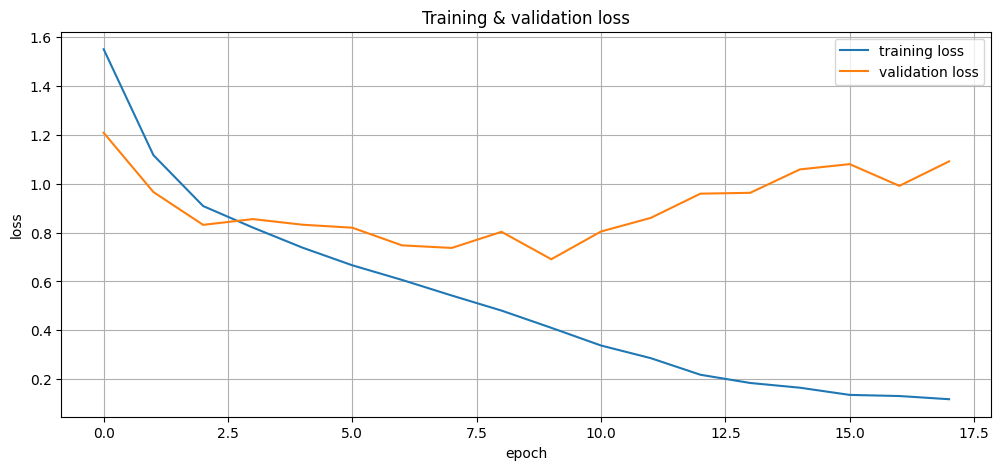

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training & validation loss')
plt.legend()
plt.grid(True)
plt.show()

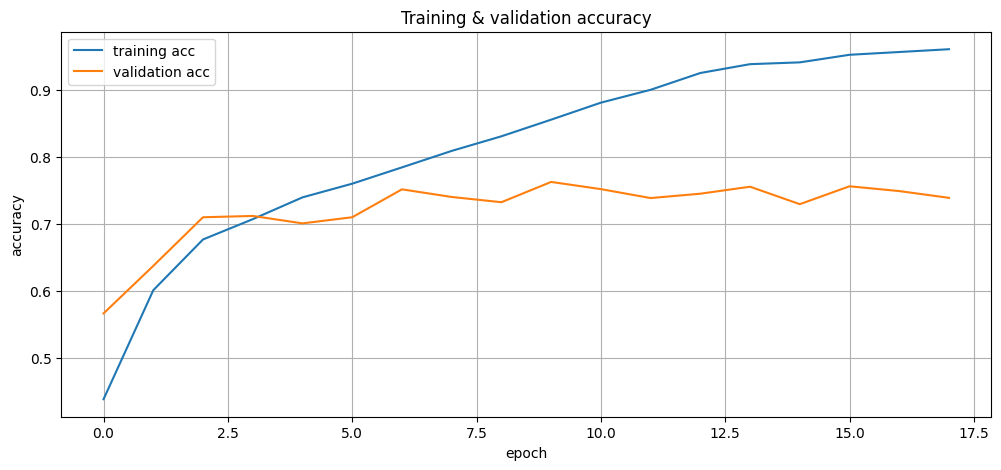

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(train_accs, label='training acc')
plt.plot(val_accs, label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training & validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-28-45dc80c2782a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_resnet_model.pth"))


best model test accuracy: 0.7630378096479792
              precision    recall  f1-score   support

    surprise       0.73      0.76      0.75       329
        fear       0.46      0.51      0.49        74
     disgust       0.46      0.41      0.44       160
   happiness       0.90      0.90      0.90      1185
     sadness       0.64      0.70      0.67       478
       anger       0.73      0.61      0.66       162
     neutral       0.74      0.72      0.73       680

    accuracy                           0.76      3068
   macro avg       0.67      0.66      0.66      3068
weighted avg       0.76      0.76      0.76      3068



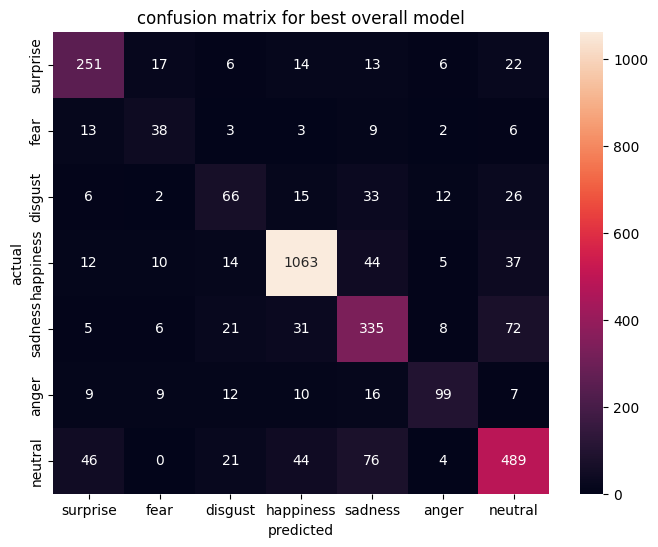

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

best_model = ResNet(num_classes=num_classes, dropout_prob=dropout_prob).to(device)
best_model.load_state_dict(torch.load("best_resnet_model.pth"))
best_model.eval()

test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = test_correct / test_total
print(f"best model test accuracy: {test_acc}")

emotion_classes = ["surprise", "fear", "disgust", "happiness", "sadness", "anger", "neutral"]
print(classification_report(y_true, y_pred, target_names=emotion_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix for best overall model")
plt.show()